In [1]:
import Zip
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time
import math
import pandas as pd

# Channels in the detector
det_ch = { 'tpc': list(range(0, 247+1)), 'veto': list(range(248, 253+1)), 
          'sum_wv': [254], 'busy_on': [255], 'busy_off': [256],
          'hev_on': [257], 'hev_off': [258], 'muon_veto_trigger': [259], } 
n_channels = 260

# The data files
NG = Zip.ReadZipped("/data/nikhefproject/data/xenon1t/NG") # Neutron data
Rn220 = Zip.ReadZipped("/data/nikhefproject/data/xenon1t/Rn220") # Rn-220 data

# Global params
#baseline = 16382.0
#std = 2.3

In [2]:
# A waveform reader function
def Waveform(eventnr):
    event = NG.get_single_event(eventnr)
                                
    #The variables that check if a channel is the minimum channel
    adcmin = 16382.
    minchannel = 0
    
    #A list that holds all the channels with significant pulses 
    channellist = []
    
    #Create the datapoint arrays
    n = 350000  
    ts = np.ones((n_channels, n), dtype=np.int16)
    ts = ts * 16382 
    t = np.linspace(0, n, n) 
    
    #Loop over all pulses in the event
    for p in event.pulses:
        ch = p.channel
        i = np.zeros(n_channels, dtype = int)
        #print(p.channel, ": ", p.left, p.right-p.left)
        for adc in p.raw_data:
            
            #Add the ADC value to the appropriate channel array
            ts[ch][p.left + i[ch]] = adc
            i[ch] = i[ch] + 1
            
            #Append all significant main channels to the list
            if adc < 15000 and ch not in channellist and ch in det_ch['tpc']:
                channellist.append(ch)
                
            #Check which channel is the minimum channel
            if adc < adcmin:
                adcmin = adc
                minchannel = ch
                
    #Sort for convenience
    channellist.sort()
    return t, ts, channellist, minchannel

In [3]:
def Peaks(pulse):
    
    # The standard variables
    q = 0
    left_t, right_t = 0, 0
    baseline = 16382.
    std = 2.3
    ch = pulse.channel
    wave = pulse.raw_data
    
    # The index for the minimum
    minindex = pulse.right
    
    # Variables for the averages
    ratio = 1
    avfound = 0
    samplelist = []

    s = np.std(wave)
    delta = baseline - np.min(wave)
    if min(s, delta) > 5*std:
        for samples in enumerate(wave):
            base_sub = samples[1] - baseline
            if abs(base_sub) > 5*std:
                q = q + base_sub
             
            # Compute the average of the previous samples
            av = np.average(samplelist)
            
            # left_t is assigned when a significant deviation from the average is recorded
            if abs(samples[1] - av) > 20 and left_t == 0:
                left_t = samples[0]
                avfound = av
             
            # Find the index for the minimum
            if samples[1] == np.min(wave):
                minindex = samples[0]

            # right_t is assigned in a similar way as left_t
            if abs(samples[1] - avfound) < 20 and samples[0] > minindex and right_t == 0: 
                right_t = samples[0]
                
            # Add the current sample to the sample list
            samplelist.append(samples[1])
        ratio = np.min(wave)/int(avfound)
    else:
        baseline = np.average(wave)
        std = s
    width = right_t - left_t 
    if width != 0 and -q/width < 3*std or ratio >= 0.99:
        q = 0
    return (ch, q, width, pulse.left+left_t, ratio)

In [10]:
info_list = []
width_list = []


for event in NG.get_events():
    if event.event_number%100 == 0:
        print(event.event_number)
    
    s1_q = 0
    s1_t0 = 0
    s2_q = 0
    s2_t0 = 0
    
    for p in event.pulses:
        if p.channel == 254:
            (ch, q, width, t0, ratio) = Peaks(p)
            if q < 0:
                width_list.append(width)
                if width < 100:
                    s1_q = -q
                    s1_t0 = t0
                else:
                    if s2_q == 0:
                        s2_t0 = t0
                    s2_q = s2_q - q
    if s1_q and s2_q:
        info = {'event': event.event_number, 's1': s1_q, 's2': s2_q, 
                's1_position': s1_t0, 's2_position': s2_t0}
        
        info_list.append(info)
    if event.event_number == 5000:
        break


0


/usr/lib/python3/dist-packages/numpy/lib/function_base.py:1110: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/lib/python3/dist-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000


In [11]:
i = 0 
for info in info_list:
    if info['s1_position'] < 99900 or info['s1_position'] > 100200:
        print(info)
        i = i + 1
print(i)

# Most t0 of s1 signals are at around "100055"
# So in this cell I picked the ones that are far away from this position
# But I still have no idea how to deal with them
# As can be seen in "drift time" indentification
# Many of these special events have : "s2" is at the left-hand side of "s1"

{'event': 3, 's1': 61482.0, 's2': 924363.0, 's1_position': 100213, 's2_position': 100733}
{'event': 21, 's1': 91085.0, 's2': 987396.0, 's1_position': 100724, 's2_position': 100184}
{'event': 160, 's1': 60728.0, 's2': 2503924.0, 's1_position': 337462, 's2_position': 106010}
{'event': 246, 's1': 76777.0, 's2': 3125914.0, 's1_position': 140975, 's2_position': 142331}
{'event': 300, 's1': 403210.0, 's2': 3950697.0, 's1_position': 144481, 's2_position': 149893}
{'event': 334, 's1': 67129.0, 's2': 1261014.0, 's1_position': 100326, 's2_position': 102129}
{'event': 342, 's1': 189478.0, 's2': 3639635.0, 's1_position': 415461, 's2_position': 130598}
{'event': 343, 's1': 65309.0, 's2': 6140054.0, 's1_position': 285704, 's2_position': 52857}
{'event': 344, 's1': 61604.0, 's2': 2099968.0, 's1_position': 146688, 's2_position': 152064}
{'event': 347, 's1': 105325.0, 's2': 5305482.0, 's1_position': 115153, 's2_position': 127888}
{'event': 348, 's1': 75755.0, 's2': 3646164.0, 's1_position': 244685, 's2

(0.0, 200)

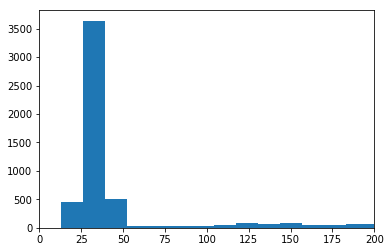

In [13]:
# Check the signal width
%matplotlib inline
fig, ax = plt.subplots()
n, bins, patches = ax.hist(width_list, 1000)
#ax.set_ylim(0., 2000)
ax.set_xlim(0., 200)

In [14]:
print(info_list[-1]['event'])

4999


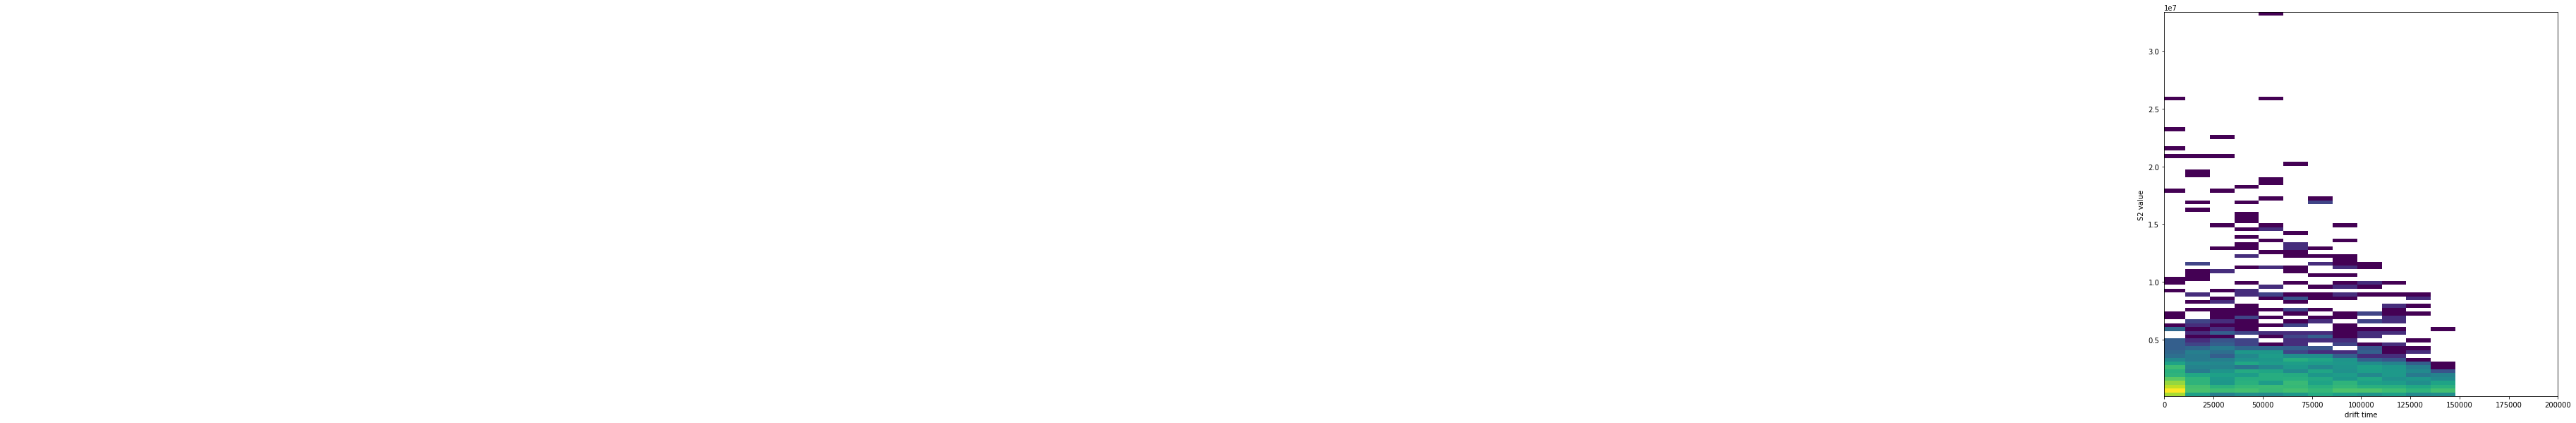

In [16]:
# Drift time
#%matplotlib inline
s1 = []
s2 = []
drift = []
for info in info_list:
    drift.append(2*(info['s2_position']-info['s1_position']))
    s1.append(info['s1'])
    s2.append(info['s2'])
fig2, ax2 = plt.subplots(figsize = (10.,10.))
ax2.hist2d(drift, s2, bins=(100,100), norm=mpl.colors.LogNorm())
ax2.set_xlabel("drift time")
ax2.set_ylabel('S2 value')
ax2.set_xlim(0., 200000)
fig2.savefig('drift.png', dpi = 300)

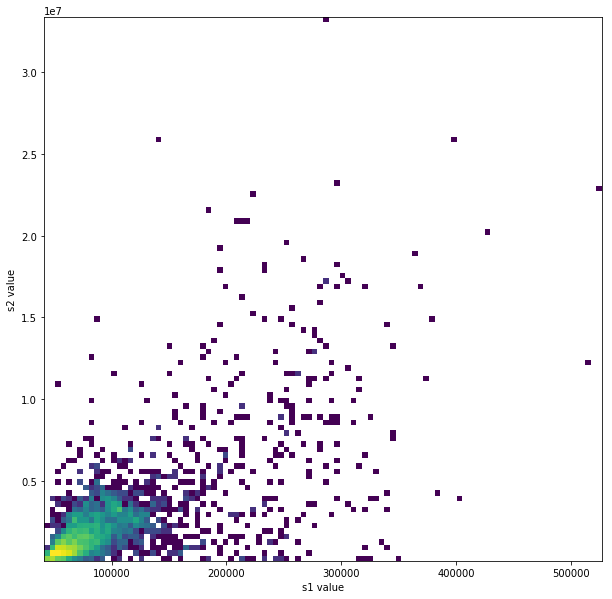

In [17]:
fig3, ax3 = plt.subplots(figsize = (10.,10.))
ax3.hist2d(s1, s2, bins=(100,100), norm=mpl.colors.LogNorm())
ax3.set_xlabel('s1 value')
ax3.set_ylabel('s2 value')
#ax3.set_xlim(0., 200000)
fig3.savefig('s1s2.png', dpi = 300)

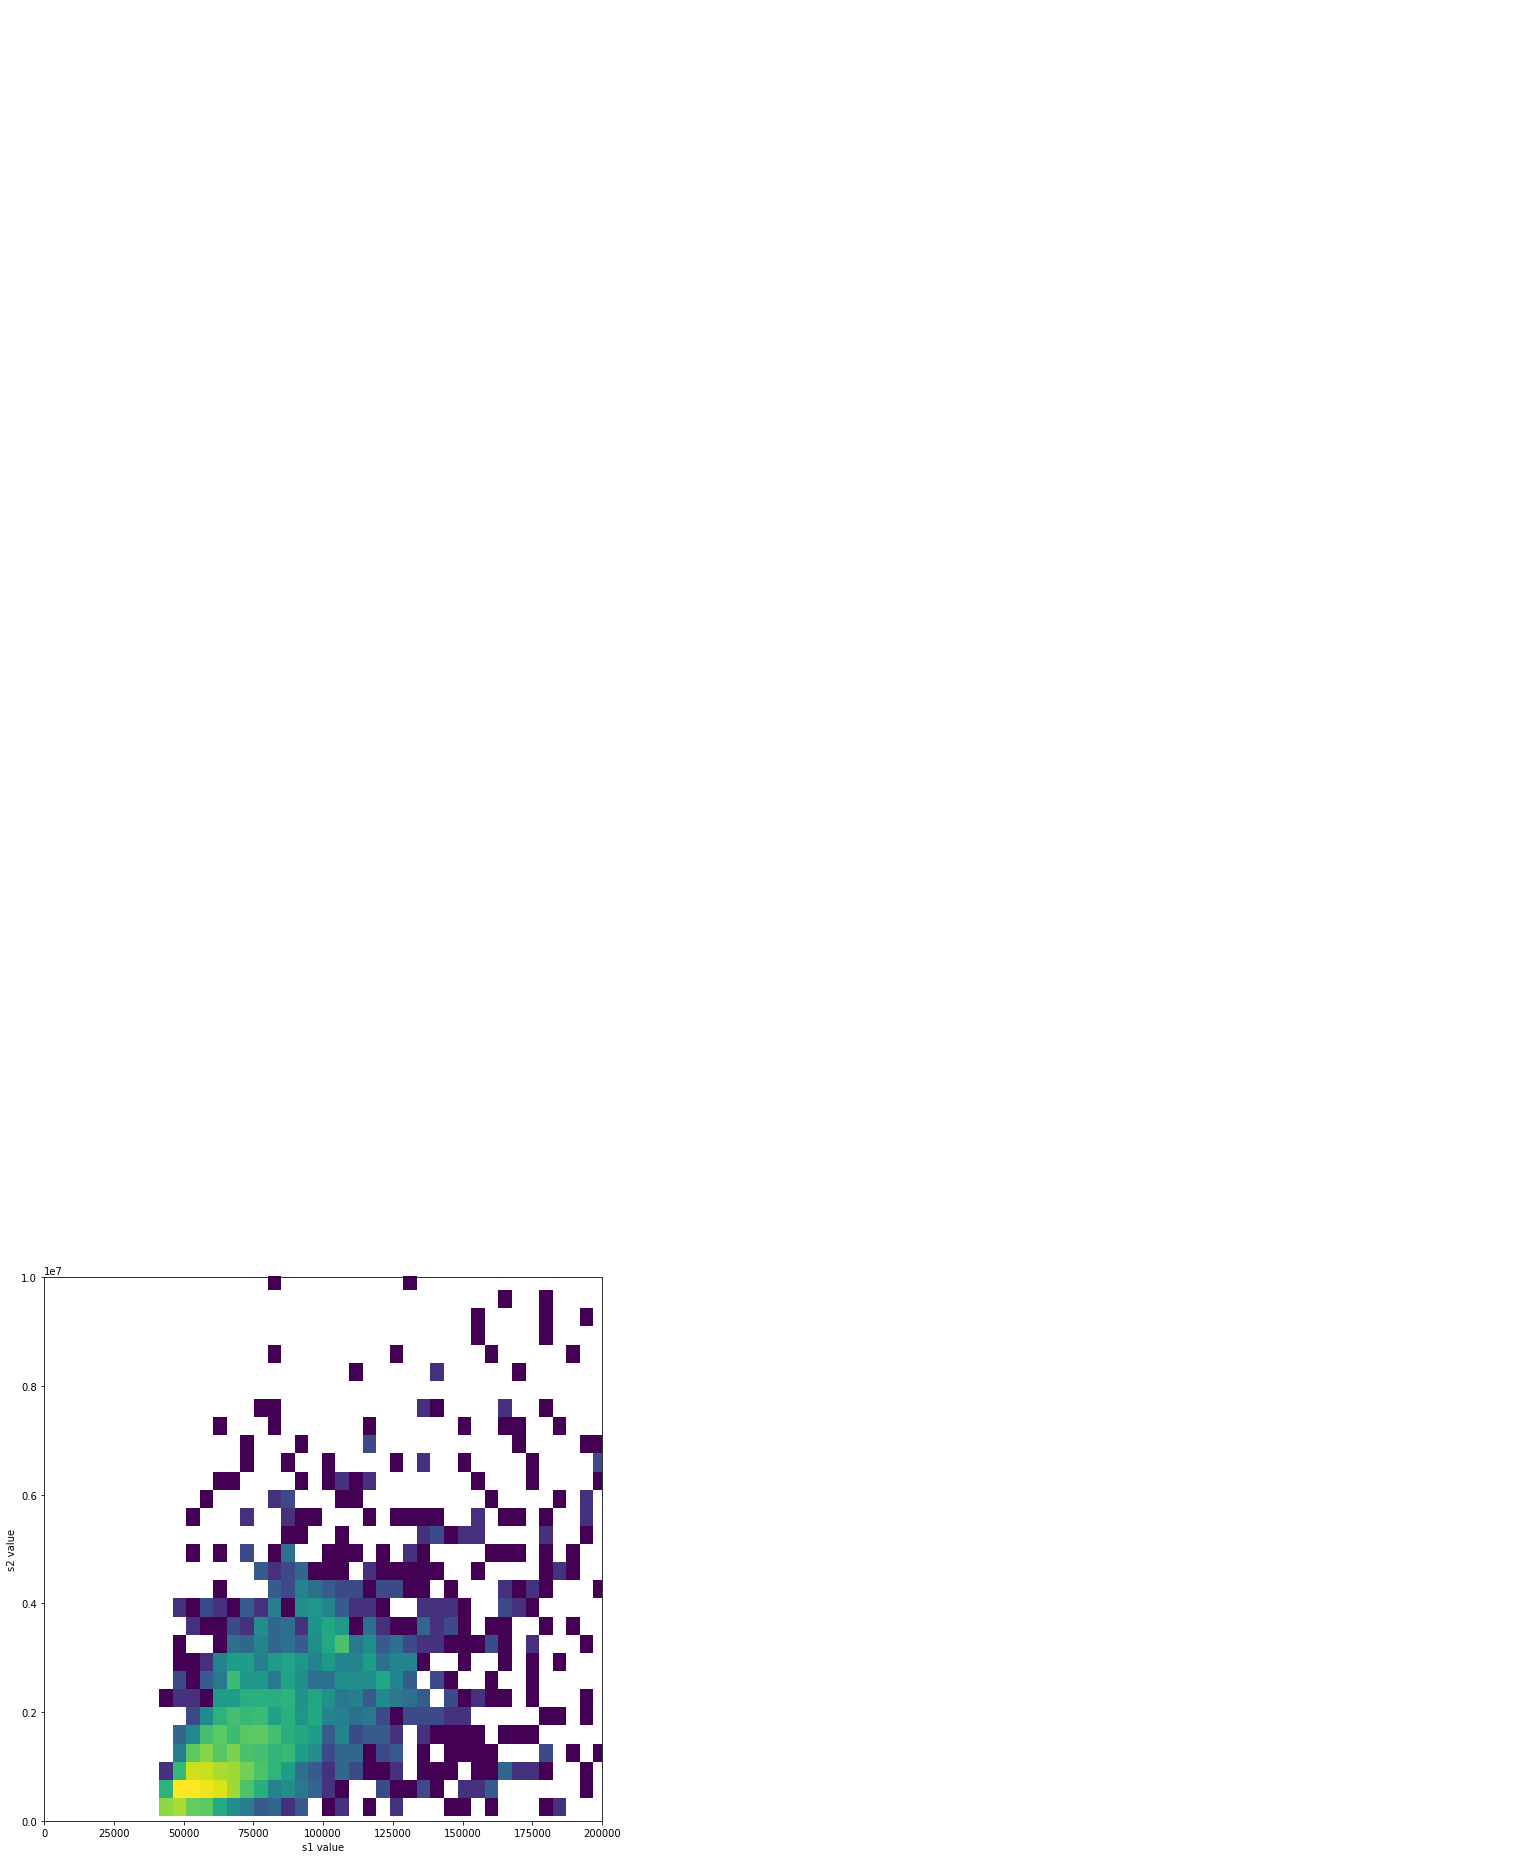

In [18]:
fig4, ax4 = plt.subplots(figsize = (10.,10.))
ax4.hist2d(s1, s2, bins=(100,100), norm=mpl.colors.LogNorm())
ax4.set_xlabel('s1 value')
ax4.set_ylabel('s2 value')
ax4.set_xlim(0., 200000)
ax4.set_ylim(0., 1e7)
fig4.savefig('s1s2_zoomin.png', dpi = 300)

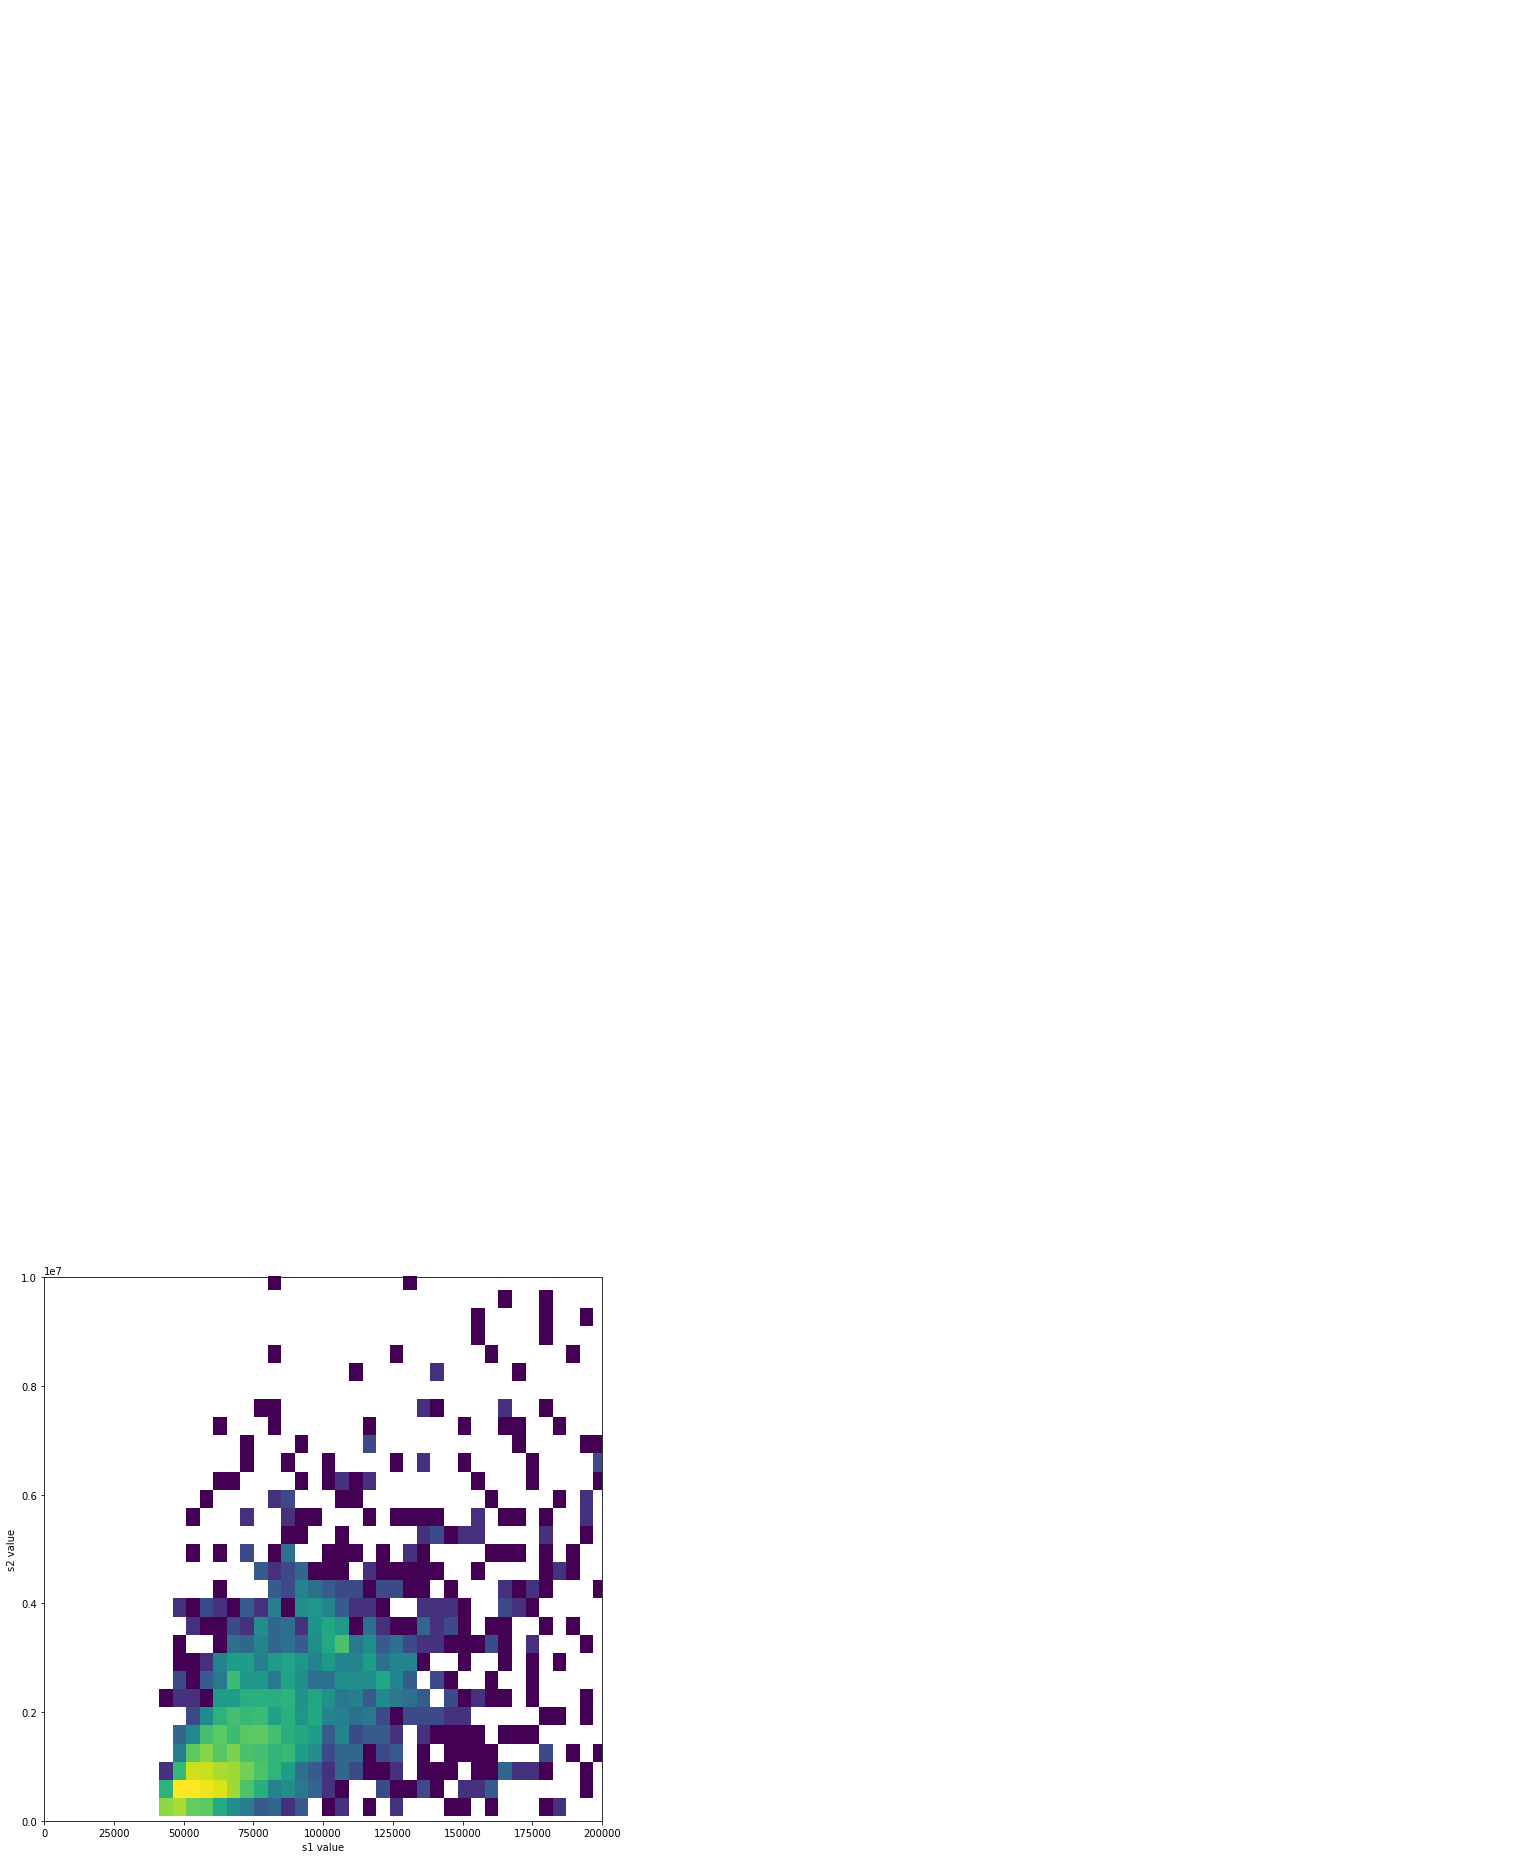

In [18]:
fig5, ax5 = plt.subplots(figsize = (10.,10.))
ax5.hist2d(s1, np.log10(s2/s1), bins=(100,100), norm=mpl.colors.LogNorm())
ax5.set_xlabel('s1 value')
ax5.set_ylabel('log10(s2/s1)')
#ax4.set_xlim(0., 200000)
#ax4.set_ylim(0., 1e7)
fig5.savefig('s2s1.png', dpi = 300)

In [9]:
# This list is going to record all channels
# Haven't check if it works

info_list_full = []
for event in NG.get_events():
    if event.event_number%10 == 0:
        print(event.event_number)
    
    s1_q = np.zeros(255)
    s1_t0 = np.zeros(255)
    s2_q = np.zeros(255)
    s2_t0 = np.zeros(255)
    
    for p in event.pulses:
        (ch, q, width, t0, ratio) = Peaks(p)
        if q < 0:
            if width < 100:
                s1_q[ch] = -q
                s1_t0[ch] = t0
            else:
                if s2_q[ch] == 0:
                    s2_t0[ch] = t0
                s2_q[ch] = s2_q[ch] - q
    for i in range(255):
        if s1_q[ch] and s2_q[ch]:
            info = {'event': event.event_number, 'ch':ch, 's1': s1_q[ch], 's2': s2_q[ch], 
                's1_position': s1_t0[ch], 's2_position': s2_t0[ch]}
            info_list_full.append(info)   
    if event.event_number == 100:
        break

0


/usr/lib/python3/dist-packages/numpy/lib/function_base.py:1110: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/lib/python3/dist-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


KeyboardInterrupt: 